# Using RAG to prevent Hallucination

Although there have been a great use of LLMs in using various tools and help in completing different tasks, there are some limitations that prevent LLMs from being deployed in sensitive fields like medicine. For example, LLMs crystalline their knowledge at the time of training and rapidly developing fields such as medical sciences cause this knowledge to be outdated in very short time. Another problem that is always concerned with LLMs is that they often hallucinate - produce contents that are factually or conceptually wrong. To overcome these, there is a new paradigm that has emerged: **retrieval-augmented generation (RAG)**. It allows for the LLM to refer to memory that is external to the model and allows knowledge to be found and keep updated. Also, providing contextual guidance to the model's response allows for reduction of hallucinations. Hence, RAG is widely used today and is considered a promising system. 

## Information Retrieval 
It is the scientific field that deals with finding information in media (often textual but also multimodal). 

Example: A user might want to find a whole document or a piece of text in documents; this task is key to question answering, where a model has to find the steps needed to answer the user's question. 

Central to this system is a **search engine**, in the case of RAG it is a Transformer.

A system that has a collection of documents (textual, but could also be web pages, images, videos, etc) that have corresponding index in the database. These documents can be associated with a metadata (attributes that describe author, size, topic, and keywords). We also have a convention where a **term** is defined as a word present in the text but also a passage that can answer the search. A user writes a **query** that can be expressed as terms. The purpose of this retrieval system is to best match the query with relevant document in the collection. These are then returned in order of relevance. 

## Implementation of TF-IDF for information retrieval and a need of modern solution using transformers

we can take a set of document and calculate the TF-IDF, and once we calculate it, we calculate a score (usually cosine-similarity) between each of the document and conduct rank based on the score. For a document **d** and a query **q** in vector form, we use the following formula:

$\cos(\mathbf{q}, \mathbf{d}) = \frac{\mathbf{q} \cdot \mathbf{d}}{\|\mathbf{q}\| \|\mathbf{d}\|}$

But for TF-IDF and also a variant of it like BM25 there are the following disadvantages 

- It is not always easy to find the optimal parameters for a precise dataset.
- The model is sensitive to choice of hyperparameters.
- Being based on term frequency, BM25 does not capture the context of a term.
- It faces problems with mismatches in vocabularies, where there is no complete overlap between terms in the query and documents.


**Possible Solution**\
To use dense vector that includes contextual information.  This is done by using transformers and extracting the representation of the document. Given a sequence of token, we use the representation *z* obtained from the final layer. This allows us to obtain a big high-dimensional representation that we can use to disambiguate the meaning of a word. This is called **z-score**.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

/home/sajalpaudyal/Documents/Programming_Works/basic_rag/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sentences = [
    "I need to go to the bank to deposit my money", 
    "My brother has gone to the bank of river for fishing", 
    "The company directly deposits my salary into my bank account",
    "The picnic is set on the bank of Godawari river", 
    "I tried withdrawing the money from my bank yesterday", 
    "There were many fisherman along the bank of the river after the flood last week", 
    "I have an appointment with the manager of the bank tomorrow",
    "It is risky to go to the river bank today, the water level is too high",
    "This bank offers loan in the minimal interest rate",
    "The erosion has brought a lot of sand to the river bank"
]

In [3]:
labels = ["money", "river","money", "river","money", "river","money", "river","money", "river"]

In [4]:
def get_word_embedding(text, word, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    tokenized_text = tokenizer.tokenize(text)
    word_index = tokenized_text.index(word)
    with torch.no_grad():
        outputs = model(**inputs)
    word_embedding = outputs.last_hidden_state[0, word_index, :].numpy()
    return word_embedding

In [5]:
model_used = "bert-base-uncased"
tokenizer  = BertTokenizer.from_pretrained(model_used)
model = BertModel.from_pretrained(model_used)

In [6]:
embeddings = np.array([get_word_embedding(sentence, "bank", model, tokenizer) for sentence in sentences])
embeddings

array([[ 0.38549128, -0.5164612 , -0.28320944, ..., -0.11805634,
         0.4499613 , -0.05410718],
       [ 0.3064443 , -0.50458634, -0.43764374, ..., -0.98827606,
         0.13129072, -0.4941981 ],
       [ 0.73640394,  0.4615822 ,  0.9363466 , ..., -0.16595432,
        -0.06706684,  0.45113388],
       ...,
       [ 0.5974556 ,  0.12453198, -0.2921982 , ..., -0.37521163,
        -0.37006932,  0.10434859],
       [-0.06798005, -0.28045896, -0.28684345, ..., -0.60608566,
         0.8571196 , -0.00506158],
       [ 0.3361669 ,  0.41064253, -0.3960354 , ..., -0.18413724,
        -0.5679618 , -0.28876424]], shape=(10, 768), dtype=float32)

In [7]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
embeddings_2d

array([[-22.818417 ,  49.807117 ],
       [ 35.92617  ,  49.11506  ],
       [-99.34352  ,  -2.1433756],
       [ 70.12161  ,  46.865025 ],
       [-72.76807  ,  -8.111011 ],
       [ 27.318644 ,  22.575602 ],
       [-25.240057 ,  21.603369 ],
       [ 25.642103 , -41.959724 ],
       [-40.532417 , -33.71208  ],
       [ 52.80442  , -41.290665 ]], dtype=float32)

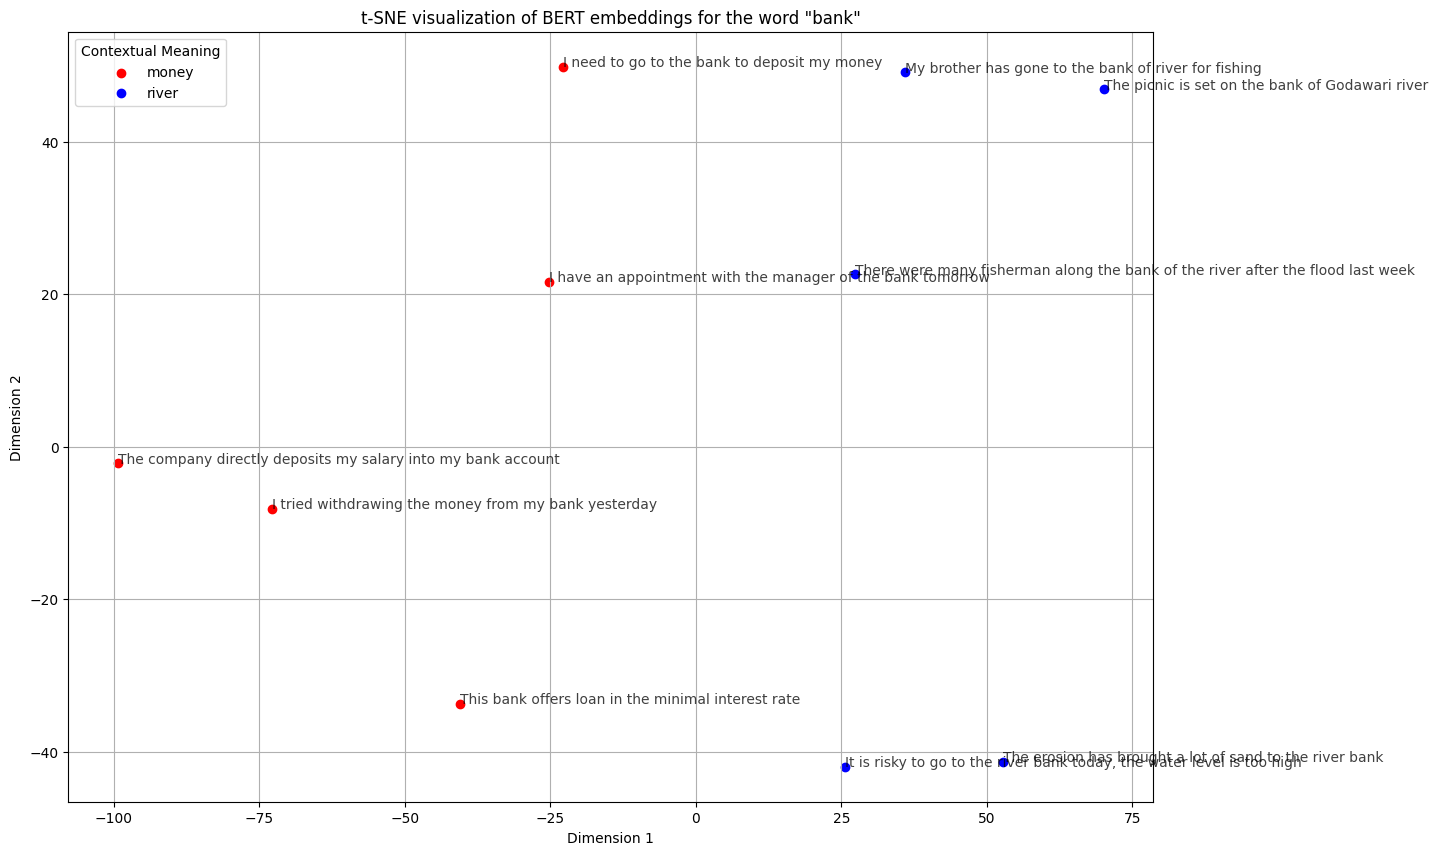

In [10]:
plt.figure(figsize=(14, 10))
colors = {'money': 'red', 'river': 'blue'}
for i, label in enumerate(labels ):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[label], label=label if (labels + ['money', 'river']).index(label) == i else "")
    plt.annotate(sentences[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10, alpha=0.75)

plt.title('t-SNE visualization of BERT embeddings for the word "bank"')
plt.xlabel('Dimension 1', fontsize=10)
plt.ylabel('Dimension 2', fontsize=10)
plt.legend(title="Contextual Meaning", loc= 'upper left')
plt.grid(True)
plt.show()